#2- Elastic Regressions

<img src="http://www.nycgo.com/images/460x285/FerrisWheel_V1_460x285.jpg"/>
<a  style="float: right;" href = 'http://www.nycgo.com/articles/a-day-in-staten-island'> (SOURCE) </a>

In this notebook, we standardized the dataset for preparation for regression. We performed two elastic net regressions: one on untransformed, unstandardized data; one on transformed, standardized data. It was shown that the second elastic regression was a more powerful predictor. 

# Table of Contents

0. [Create dataframes](#0)
2. [Elastic Net Regression](#2)

In [50]:
%matplotlib inline
import csv
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import scipy
import scipy.stats

In [51]:
np.set_printoptions(suppress=True)

#NOTE: THIS NOTEBOOK REQUIRES THE PICKLE MADE FROM BOOK 1
##If you have run Book 1, run this:

In [52]:
cleandf = pd.read_pickle('cleandf')

##If you  have *NOT* run Book 2, or there was some issue with the pickle, run this instead:

In [53]:
#cleandf = pd.read_pickle('Data/cleandf')

#Now we begin...

<a id='0' ></a>
## Create dataframes

In this section, we create 2 different dataframes to be used in different sections of our statistical analysis. One dataframe "dftouse" is our cleaned dataframe with certain features having been log-transformed. A second dataframe "standarddf" has additionally been standardized. In pursuing our regressions, it will be important to note the statistical validity in using standardized variables for our predictions.

In [54]:
dftouse=cleandf.copy()

### Transform skewed features

We transform those variables that are severely right-skewed so that we are working with Normal-looking distributions. Due to the handful of skyscrappers in New York, which accompany the houses and apartments of the masses, there are a number of metrics with severe outliers that end up skewing the whole distribution. We seek to standardize the distributions in order to avoid the trap of "garbage in, garbage out." With screwy inputs, we'll get screwy output.

In these transformations, we add 1 where there are 0s in the data because you can't take the log of 0.

In [55]:
dftouse['Log_ResidentialUnits'] = np.log(dftouse['RESIDENTIAL UNITS'].values+1)
dftouse['Log_CommercialUnits'] = np.log(dftouse['COMMERCIAL UNITS'].values+1)
dftouse['Log_TotalUnits'] = np.log(dftouse['TOTAL UNITS'].values+1)
dftouse['Log_GrossSqft'] = np.log(dftouse['GROSS SQUARE FEET'].values)
dftouse['Log_1count'] = np.log(dftouse['1-count'].values)
dftouse['Log_2count'] = np.log(dftouse['2-count'].values)
dftouse['Log_3count'] = np.log(dftouse['3-count'].values)
dftouse['Log_Hospitals'] = np.log(dftouse['Hospitals'].values+1)

### Standardize features

A log transform will often ensure a normal distribution. But, these normal distributions are essentially guaranteed to have different means and standard deviations. In order to obtain normal distributions with approximately the same mean and standard deviation, we standardize. Often this is performed by subtracting by the mean and dividing by the standard deviation.

In [56]:
standarddf = dftouse

In [57]:
PERCENT_VARS=[ u'High School Graduation Rate', u'College Graduation Rate', u'Hispanic', u'Black', u'Asian', 
              u'White', u'Labor Force', u'Employed', u'Unemployed' ]
STANDARDIZABLE = PERCENT_VARS + [u'Log_Sale_Price', u'Log_Price_Sqft', u'Log_ResidentialUnits', u'Log_CommercialUnits',
                                 u'Log_TotalUnits', u'Log_GrossSqft', u'Log_1count', u'Log_2count', u'Log_3count',
                                 u'Log_Hospitals', u'1-mean_log_Pft', u'1-std_log_Pft', u'1-median_log_Pft',
                                 u'2-mean_log_Pft', u'2-std_log_Pft', u'2-median_log_Pft',
                                 u'3-mean_log_Pft', u'3-std_log_Pft', u'3-median_log_Pft', u'Population']
continuous_test_features = ['Log_TotalUnits','YEAR BUILT', 'YEAR',
                 '1-mean_log_Pft', '1-std_log_Pft', 'Log_1count','1-median_log_Pft',
                 '2-mean_log_Pft', '2-std_log_Pft', 'Log_2count','2-median_log_Pft',
                 '3-mean_log_Pft', '3-std_log_Pft', 'Log_3count','3-median_log_Pft',
                 'Log_Hospitals', 'High School Graduation Rate', 'College Graduation Rate',
                 'Hispanic', 'Black', 'Asian', 'White','Labor Force', 'Employed', 'Unemployed', 'Population']

In [58]:
#adpoted from homework3
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [59]:
#adopted from homework3
from sklearn.preprocessing import StandardScaler
for col in STANDARDIZABLE:
    print col
    valstrain=standarddf[col].values[mask]
    valstest=standarddf[col].values[~mask]
    scaler=StandardScaler().fit(valstrain)
    outtrain=scaler.transform(valstrain)
    outtest=scaler.fit_transform(valstest)
    out=np.empty(mask.shape[0])
    out[mask]=outtrain
    out[~mask]=outtest
    standarddf[col]=out

High School Graduation Rate
College Graduation Rate
Hispanic
Black
Asian
White
Labor Force
Employed
Unemployed
Log_Sale_Price
Log_Price_Sqft
Log_ResidentialUnits
Log_CommercialUnits
Log_TotalUnits
Log_GrossSqft
Log_1count
Log_2count
Log_3count
Log_Hospitals
1-mean_log_Pft
1-std_log_Pft
1-median_log_Pft
2-mean_log_Pft
2-std_log_Pft
2-median_log_Pft
3-mean_log_Pft
3-std_log_Pft
3-median_log_Pft
Population


#### Plot standardized variables
Here we plot each of the features, most of which are now transformed and standardized. Ideally, we see all standard normal distributions, centered about 0 with a standard deviation of 1.

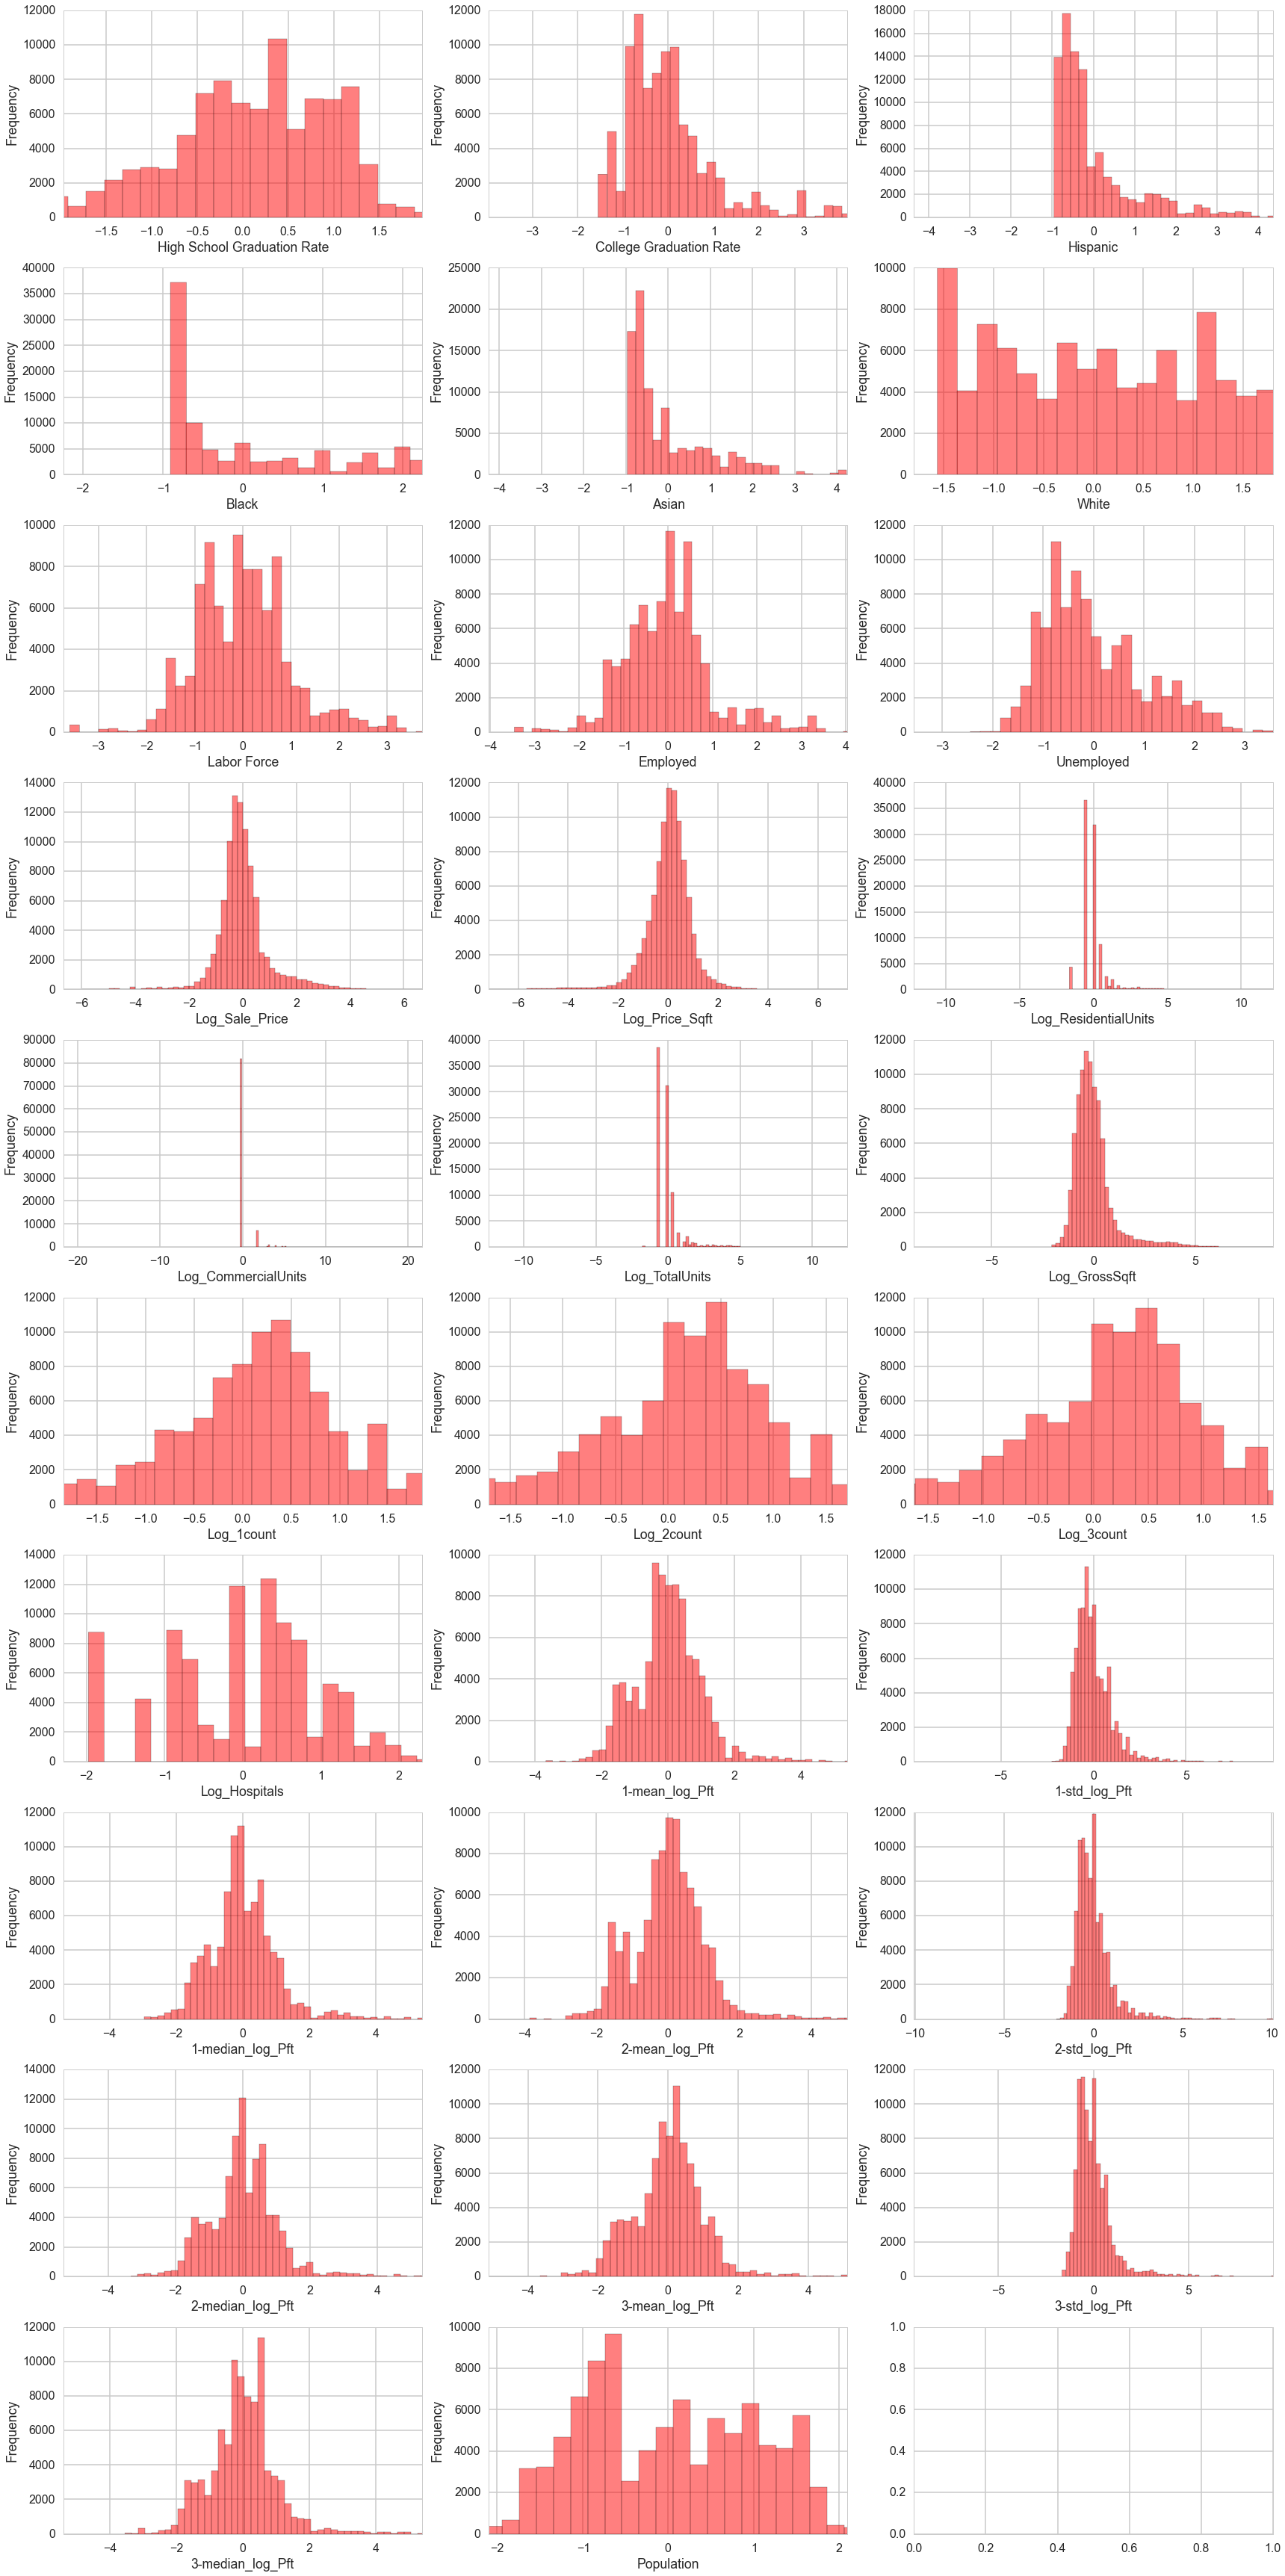

In [60]:
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(24, 48), tight_layout=True)

for ax, col in zip(axes.ravel(), STANDARDIZABLE):
    binwidth = .2
    ax.hist(standarddf[col].values,alpha=0.5, color="red", 
            bins=np.arange(min(standarddf[col].values), max(standarddf[col].values) + binwidth, binwidth))
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    upperb = max(standarddf[col].values)
    lowerb = -upperb
    ax.set_xlim([lowerb,upperb])

Some of these distributions must have been screwed up in the StandardScaler transform. Notably, Log_1count, Log_2count, Log_3count, Log_Hospitals, and Log_GrossSqft are not centered about 0.

## Elastic Net Regression

We ran a standard linear regression on our dataset first to see what kind of predictions we would get given an assumption of a correct model. Although lacking in the added information and complexity of a model such as Bayesian regression, it would give us a baseline to work off of and something that we could later compare against.

Our initial instinct was to avoid least squares regression because of its tendency to overfit. Additionally for least squares, multicollinearity leads to high estimator variance. We wanted to avoid this because our data (with many zipcode-level features) likely has multicollinearity.

We opted for elastic net regression. For our purposes, elastic is more favorable than vanilla Lasso regression because of its ability to incorporate Ridge regression, which is sensitive to correlation between different predictors. Elastic has the capability to use parameters from Ridge and Lasso regressions in a balance. While elastic net could lead to larger and more complex models that may be harder to train, it will on average be more accurate and allow us to select for all of our predictors.

### First, perform regression on the cleandf

We first apply the regression to the cleandf. Again, this df does not include transformed features and we will predict on price_ft. This will create our (poor) baseline regression model.

In [61]:
Y_col = np.array(cleandf['price_ft'])

In [62]:
clean_test_features = ['TOTAL UNITS','YEAR BUILT','YEAR',
                 '1-mean_log_Pft', '1-std_log_Pft', '1-count','1-median_log_Pft',
                 '2-mean_log_Pft', '2-std_log_Pft', '2-count','2-median_log_Pft',
                 '3-mean_log_Pft', '3-std_log_Pft', '3-count','3-median_log_Pft',
                 'Hospitals', 'Bad Hospitals', 'High School Graduation Rate', 'College Graduation Rate',
                 'Hispanic', 'Black', 'Asian', 'White','Labor Force', 'Employed', 'Unemployed', 'Population']

In [63]:
X_cols = np.array(cleandf[clean_test_features])

In [64]:
Y_col.shape, X_cols.shape

((92139,), (92139, 27))

#### Find optimal hyperparameters of elastic net regression.
We split into training and test sets, so we can test our results later.

In [65]:
from sklearn import linear_model
from sklearn import cross_validation

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_cols, Y_col, \
                                                                     test_size=0.3, random_state=0)

print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(64497, 27) (64497,)
(27642, 27) (27642,)


In [66]:
alphas = [0., 0.001, 0.1, 0.2, 0.4, 0.6, 0.8, 1.]
ratios = [.1, .5, .7, .9, .95, .99, 1]

elastic_net = 0
#adapted from the homework
def find_hyperparams(alphas, ratios, X_train, X_test, y_train, y_test):
    results = []
    scores = [[0 for i in range(7)] for j in range(8)]
    ratiolist = [[0 for i in range(7)] for j in range(8)]
    best_fit = float('-inf')
    params = None
    for k,i in enumerate(alphas):
        for kk, j in enumerate(ratios):
            print "Current: " +str(i)+", "+str(j)
            elastic_net = linear_model.ElasticNet(alpha=i, l1_ratio=j, fit_intercept=True, normalize=False)
            elastic_net.fit(X_train, y_train)
            score = elastic_net.score(X_test, y_test)
            scores[k][kk]=score
            ratiolist[k][kk]=j
            results.append(score)
            print "  Score: " + str(score)
            if score > best_fit:
                print "  New best fit: "+str(score)+'\n'
                best_fit = score
                params = elastic_net.get_params()
                
    return best_fit, params, results, scores, ratiolist

We test different combinations of parameters (alpha and ratios). These parameters dictate how much Ridge and Lasso regression effects are included on top of the fundamental OLS regression. Using sklearn's ElasticNet's package, we can "score" each of these combinations. As mentioned in the documentation, a high score corresponds to a high $R^2$ metric, with a maximum value of 1. $R^{2}$ is defined as $(1 - \frac{u}{v})$, where u is the regression sum of squares $\Sigma(y_{true} - y_{pred})^2$ and v is the residual sum of squares $\Sigma((y_{true} - mean(y_{true}))^2)$.

In [67]:
bestfit, params, score, scores, ratiolist = find_hyperparams(alphas, ratios, X_train, X_test, y_train, y_test)

Current: 0.0, 0.1
  Score: 0.127810062569
  New best fit: 0.127810062569

Current: 0.0, 0.5
  Score: 0.127810062569
Current: 0.0, 0.7
  Score: 0.127810062569
Current: 0.0, 0.9
  Score: 0.127810062569
Current: 0.0, 0.95
  Score: 0.127810062569
Current: 0.0, 0.99
  Score: 0.127810062569
Current: 0.0, 1
  Score: 0.127810062569
Current: 0.001, 0.1
  Score: 0.12810299608
  New best fit: 0.12810299608

Current: 0.001, 0.5
  Score: 0.128035432519
Current: 0.001, 0.7
  Score: 0.127950806827
Current: 0.001, 0.9
  Score: 0.127838070075
Current: 0.001, 0.95
  Score: 0.127817801703
Current: 0.001, 0.99
  Score: 0.127814437428
Current: 0.001, 1
  Score: 0.12781089551
Current: 0.1, 0.1
  Score: 0.11960275863
Current: 0.1, 0.5
  Score: 0.122522486343
Current: 0.1, 0.7
  Score: 0.124305251625
Current: 0.1, 0.9
  Score: 0.126499308645
Current: 0.1, 0.95
  Score: 0.127326757249
Current: 0.1, 0.99
  Score: 0.127963163838
Current: 0.1, 1
  Score: 0.127891432093
Current: 0.2, 0.1
  Score: 0.114896433434
Cu

/Users/Jimmy/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


#### Optimizing Hyperparameters

Below are plots of each combination of parameters and the combination's resulting score. The lower the alpha values the better. Each subplot represents one value of alpha, and ratio varies along the x axis.

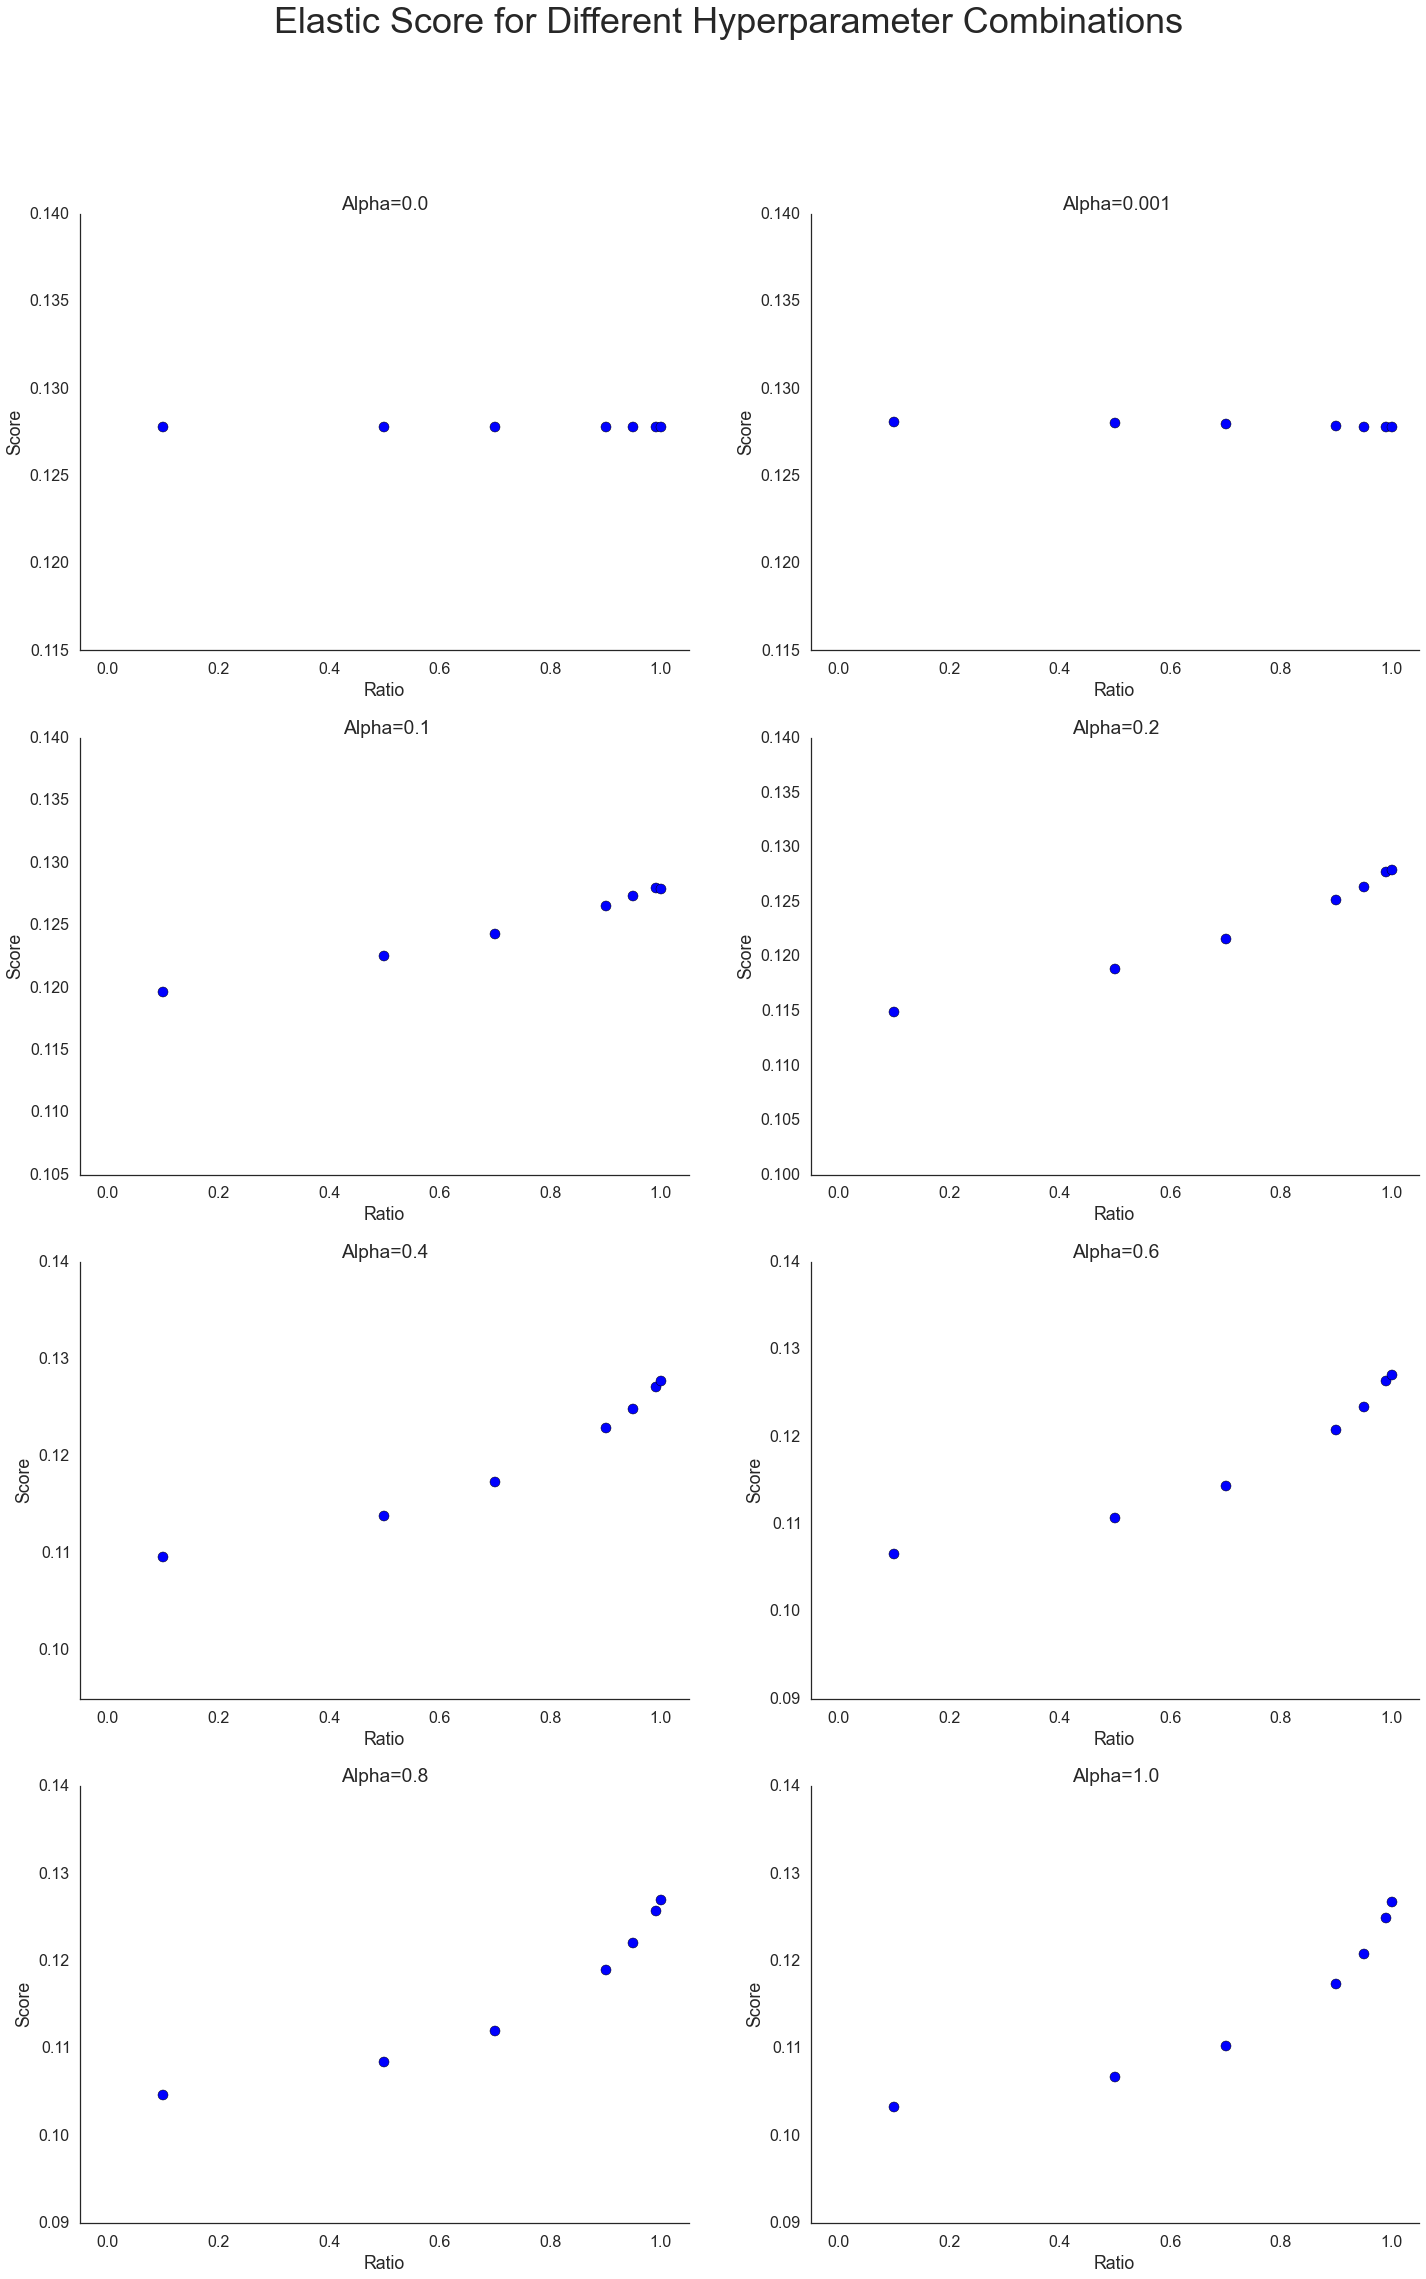

In [68]:
sns.set_style('white')
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(24, 36), tight_layout=False)
for k, ax in enumerate(zip(axes.ravel())):
    ax[0].scatter(ratiolist[k],scores[k],s=100)
    ax[0].set_title('Alpha='+str(alphas[k]))
    ax[0].set_xlabel('Ratio')
    ax[0].set_ylabel('Score')
    ax[0].set_xlim(-.05,1.05)
    sns.despine()

plt.suptitle('Elastic Score for Different Hyperparameter Combinations',fontsize =36)
plt.show() 

#### Run elastic using specified hyperparameters
The cross-validation found $alpha=0, ratio = .1$. This result shows that just a normal OLS model (without the added Lasso and Ridge regression regularizations) is the best.

In [69]:
elastic = linear_model.ElasticNet(alpha=0, l1_ratio=.1, fit_intercept=True, normalize=False)
elastic.fit(X_train, y_train)
y_preds = elastic.predict(X_test)
print y_preds

[ 298.41692756   99.97056558  326.06988146 ...,  449.0836269   352.88633153
  448.88694908]


/Users/Jimmy/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  from IPython.kernel.zmq import kernelapp as app


One way to assess goodness of fit is by the root mean square error.

In [70]:
#from the homework 
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

In [71]:
get_rmse(y_test,y_preds)

425.25059936976413

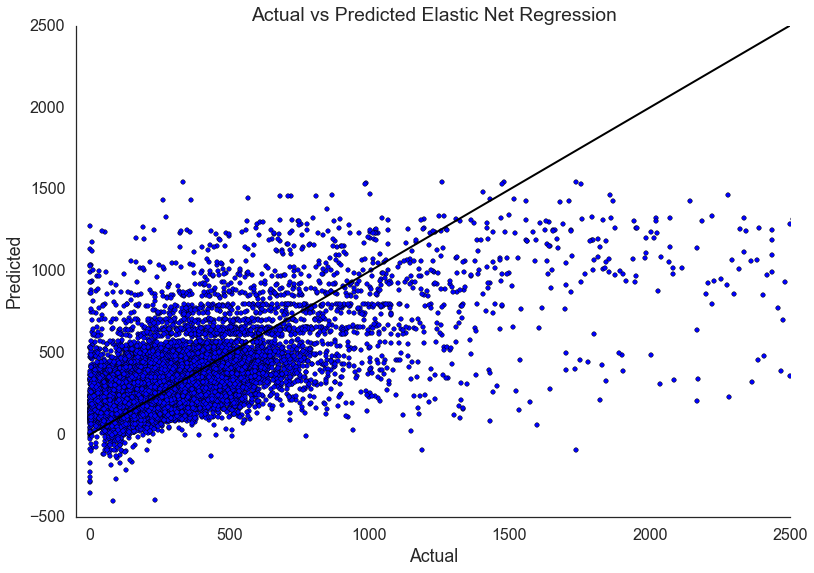

In [72]:
fig, ax = plt.subplots()
ax.scatter(y_test,y_preds)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.xlim(-50,2500)
plt.ylim(-500,2500)
plt.title('Actual vs Predicted Elastic Net Regression')
ax.plot([-4, 2500], [-4, 2500], color='k', linestyle='-', linewidth=2)
sns.despine()
plt.show()

Another way to assess how good the model's predictions are is to look at the pearson correlation coefficient. For this metric, a 1 represents perfect accuracy, 0 represents no correlation, and -1 represents opposite correlation.

In [73]:
from scipy.stats.stats import pearsonr

def pearson_scorer(pred,actual):
    rho, pvals = pearsonr(pred, actual)   
    print rho, pvals
    
    return np.abs(rho), pvals

In [74]:
pearson_scorer(y_preds,y_test)

0.365290826276 0.0


(0.36529082627582515, 0.0)

This is not a very good correlation. This is meant as a baseline: it can definitely be improved. In looking at the predicted vs actual graph, the regression does a particularly poor job in estimating expensive homes.

### Second, perform regression on the loggeddf

Performing the same sort of regression, only using transformed variables where applicable. This should help our model considerably. The same steps are followed as above.

In [75]:
Y_col2 = np.array(dftouse['Log_Price_Sqft'])

In [76]:
X_cols2 = np.array(dftouse[continuous_test_features])

In [77]:
Y_col2.shape, X_cols2.shape

((92139,), (92139, 26))

In [78]:
X_train2, X_test2, y_train2, y_test2 = cross_validation.train_test_split(X_cols2, Y_col2, \
                                                                     test_size=0.3, random_state=0)

print X_train2.shape, y_train2.shape
print X_test2.shape, y_test2.shape

(64497, 26) (64497,)
(27642, 26) (27642,)


In [79]:
alphas2 = [0., 0.001, 0.1, 0.2, 0.4, 0.6, 0.8, 1.]
ratios2 = [.1, .5, .7, .9, .95, .99, 1]

elastic_net = 0

In [80]:
bestfit2, params2, score2, scores2, ratiolist2 = find_hyperparams(alphas2, ratios2, X_train2, X_test2, y_train2, y_test2)

Current: 0.0, 0.1
  Score: 0.286125627567
  New best fit: 0.286125627567

Current: 0.0, 0.5
  Score: 0.286125627567
Current: 0.0, 0.7
  Score: 0.286125627567
Current: 0.0, 0.9
  Score: 0.286125627567
Current: 0.0, 0.95
  Score: 0.286125627567
Current: 0.0, 0.99
  Score: 0.286125627567
Current: 0.0, 1
  Score: 0.286125627567
Current: 0.001, 0.1
  Score: 0.286256502242
  New best fit: 0.286256502242

Current: 0.001, 0.5
  Score: 0.286491409044
  New best fit: 0.286491409044

Current: 0.001, 0.7
  Score: 0.286590659996
  New best fit: 0.286590659996

Current: 0.001, 0.9
  Score: 0.286672441375
  New best fit: 0.286672441375

Current: 0.001, 0.95
  Score: 0.286688067763
  New best fit: 0.286688067763

Current: 0.001, 0.99
  Score: 0.286699538614
  New best fit: 0.286699538614

Current: 0.001, 1
  Score: 0.286702280955
  New best fit: 0.286702280955

Current: 0.1, 0.1
  Score: 0.280992361188
Current: 0.1, 0.5
  Score: 0.264254745449
Current: 0.1, 0.7
  Score: 0.256062469221
Current: 0.1, 0.

/Users/Jimmy/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


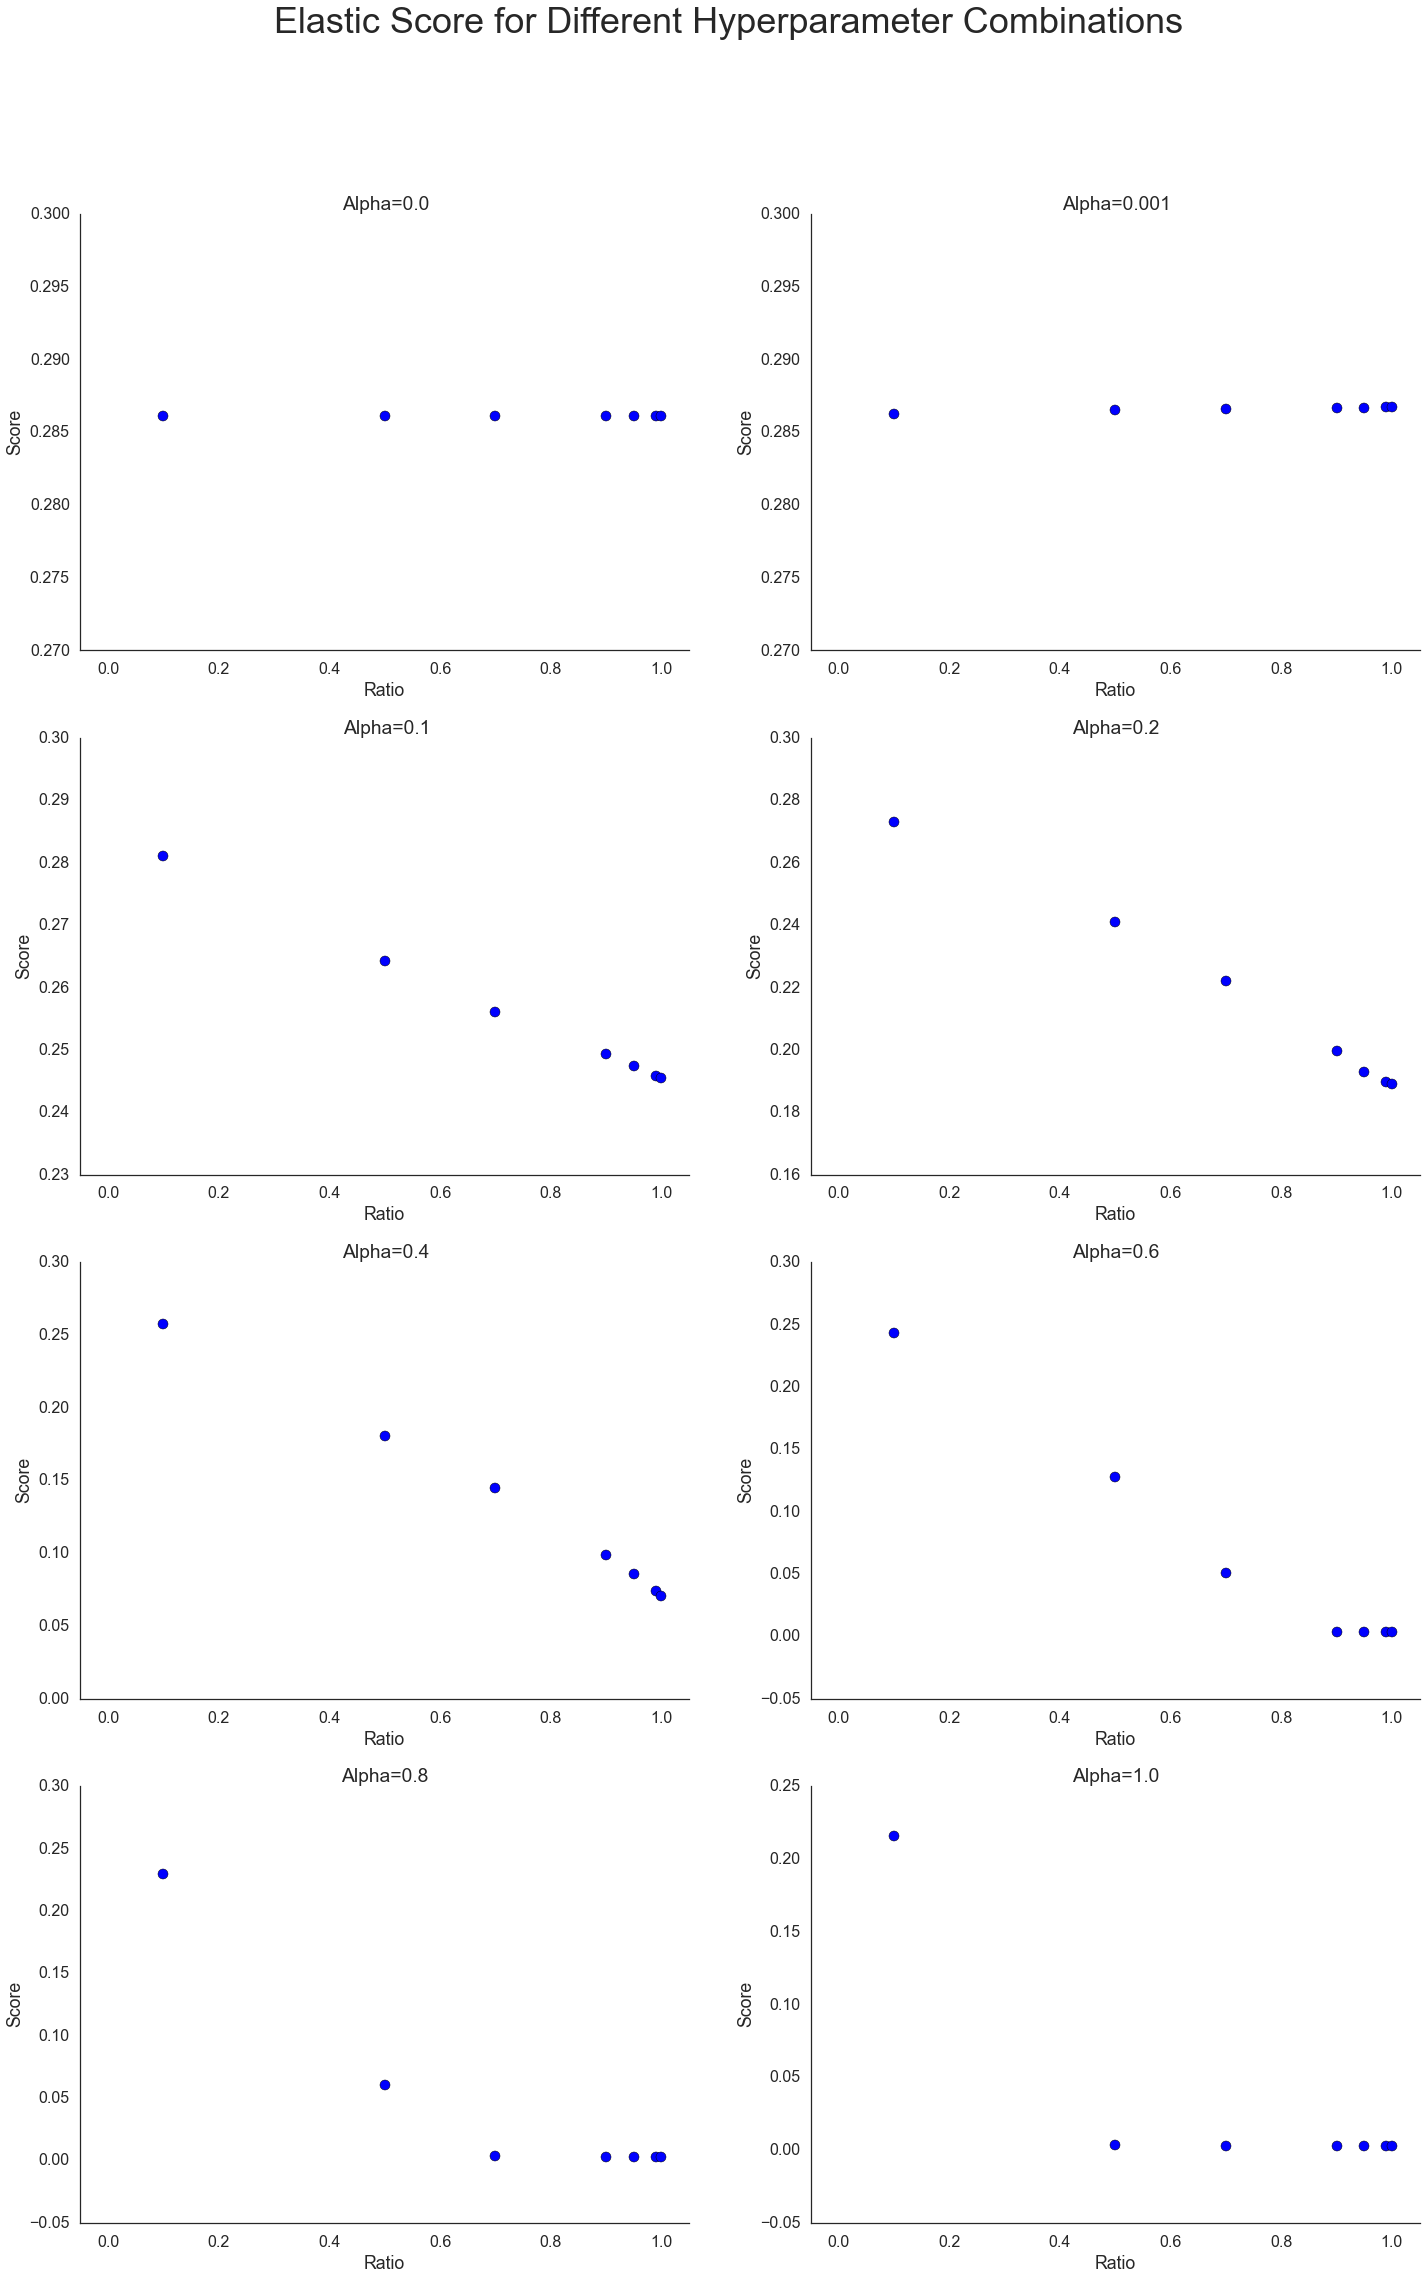

In [81]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(24, 36), tight_layout=False)
for k, ax in enumerate(zip(axes.ravel())):
    ax[0].scatter(ratiolist2[k],scores2[k],s=100)
    ax[0].set_title('Alpha='+str(alphas[k]))
    ax[0].set_xlabel('Ratio')
    ax[0].set_ylabel('Score')
    ax[0].set_xlim(-.05,1.05)
    sns.despine()

plt.suptitle('Elastic Score for Different Hyperparameter Combinations',fontsize =36)
plt.show() 

In [82]:
elastic2 = linear_model.ElasticNet(alpha=0, l1_ratio=.1, fit_intercept=True, normalize=False)
elastic2.fit(X_train2, y_train2)
y_preds2 = elastic2.predict(X_test2)
print y_preds2

[ 0.47050501 -0.63089512  0.35046367 ...,  0.48049546  0.29114191
  0.60449071]


/Users/Jimmy/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  from IPython.kernel.zmq import kernelapp as app


In [83]:
get_rmse(y_test2,y_preds2)

0.84817896833946615

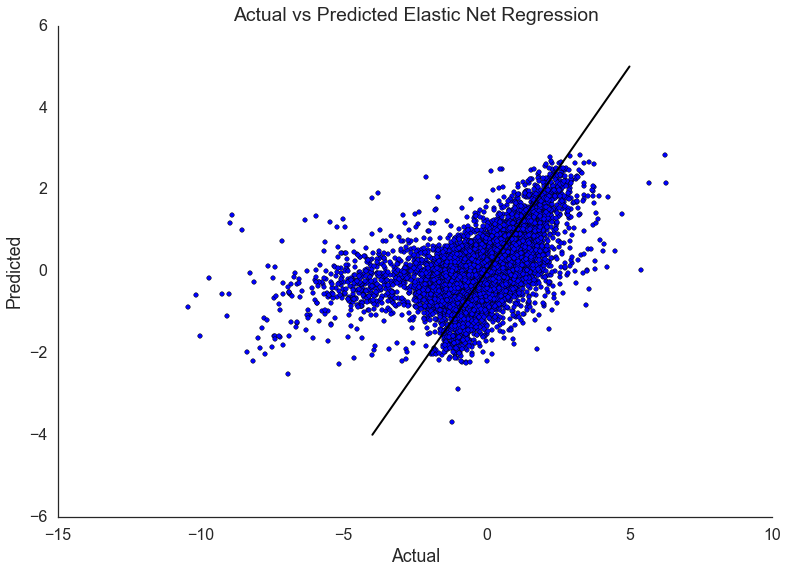

In [84]:
fig = plt.figure()
sns.despine()
plt.scatter(y_test2,y_preds2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Elastic Net Regression')
plt.plot([-4, 5], [-4, 5], color='k', linestyle='-', linewidth=2)
sns.despine()
#plt.savefig('Reg2.png', transparent = True)
plt.show()



In [85]:
pearson_scorer(y_preds2,y_test2)

0.534928109933 0.0


(0.53492810993262485, 0.0)

The pearson correlation coefficient is helpful because it can be compared to other models not on the same scale (like the model above). Here a correlation of .51 is good, and decently better than the elastic on cleandf.